### 主要用到gensim的Word2Vec这个方法
- 一些参数介绍
    - sentences 二维list，第二维是分好词的list
    - sg 0表示CBOW 1 Skip-gram
    - size 特征向量的维度 默认100维
    - window 表示当前词与预测词在一个句子中的最大距离是多少
    - alpha 是学习速率
    - min_count 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
    - workers 参数控制训练的并行数。
    - hs 如果为1则会采用hierarchical softmax技巧。如果设置为0（defaut），则negative sampling会被使用。

#### 第一种方法：读取 生文本，整个是一个文档

In [1]:
import pandas as pd
import numpy as np
import jieba
import logging
import os
from gensim.models import word2vec

In [2]:
# 把整个文件读取并分词之后写入到另外一个文件
dataFile = 'data/in_the_name_of_people.txt'
with open(dataFile, 'rb') as f:
    document = f.read()
    document_cut = jieba.cut(document)
    result = ' '.join(document_cut)
    result = result.encode('utf-8')
    with open('data/in_the_name_of_people_segment.txt', 'wb+') as f2:
        f2.write(result)

f.close()
f2.close()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/g_/rv2sg65j1_g2znz05v_snmth0000gn/T/jieba.cache
Loading model cost 0.701 seconds.
Prefix dict has been built succesfully.


In [3]:
# 基础log配置

logging.basicConfig(filename="config.log",filemode="w",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)

In [4]:
# 得到的是一个每一行分好词的二维list
sentences = word2vec.LineSentence('data/in_the_name_of_people_segment.txt')

In [5]:
model_1 = word2vec.Word2Vec(sentences, hs=1, min_count=1, window=3, size=100)
model_1.most_similar('祁同伟')

/Users/shinkeika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('李达康', 0.9543625116348267),
 ('高育良', 0.9395586252212524),
 ('赵瑞龙', 0.932272732257843),
 ('又', 0.9235411882400513),
 ('陈海', 0.9098867177963257),
 ('同学', 0.9096698760986328),
 ('一下', 0.9070384502410889),
 ('赵家', 0.9039739966392517),
 ('赶快', 0.9034817218780518),
 ('了', 0.9020516872406006)]

In [6]:
model_1.save("data/w2v_1")

#### 第二种方法：读取 csv，一行一句话

In [7]:
import jieba.posseg

In [8]:
# 读取数据集
dataFile = 'data/sample_data.csv'
data = pd.read_csv(dataFile)

In [9]:
# 组装数据
def dataPrepos(text):
    l = []
    pos = ['n', 'nz', 'v', 'vd', 'vn', 'l', 'a', 'd']  # 定义选取的词的词性
    seg = jieba.posseg.cut(text)  # 分词
    for i in seg:
        if i.word and i.flag in pos:  # 词性筛选
            l.append(i.word)
    return l

corpus = []
for index in range(len(data['id'])):
    text = '%s。%s' % (data['title'][index], data['abstract'][index])
    text = dataPrepos(text)  # 文本预处理
    text = ' '.join(text)
    corpus.append(text)


In [10]:
corpusA = [i.split(' ') for i in corpus]

In [11]:
model_2 = word2vec.Word2Vec(corpusA, size=100, window=5, min_count=1, workers=4, sg = 1, negative = 5, ns_exponent = 0.75)


In [12]:
model_2.most_similar('最靠近')

/Users/shinkeika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('支承', 0.358076810836792),
 ('处在', 0.32326364517211914),
 ('内燃机', 0.31486743688583374),
 ('具有', 0.31251758337020874),
 ('容量', 0.31163859367370605),
 ('到', 0.3025762140750885),
 ('支撑', 0.30049246549606323),
 ('覆盖', 0.29073700308799744),
 ('本发明', 0.2883431017398834),
 ('位置', 0.2784442901611328)]

In [13]:
model_2.save("data/w2v_2")

In [14]:
model_2 = word2vec.Word2Vec.load('data/w2v_2')

#### 数据可视化

/Users/shinkeika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/shinkeika/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shinkeika/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


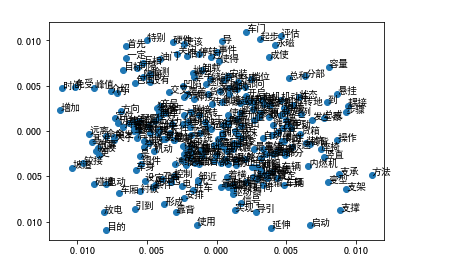

In [18]:
# 基于2d PCA拟合数据
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model_2[model_2.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# 可视化展示
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_2.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.xlim(-0.012, 0.012)
pyplot.ylim(-0.012, 0.012)
pyplot.show()